# Prepare Data
## Target Specification:

1. Gasoline: FIC15613, GSO_FLOW
2. Lean Gas: FI18301, LGO_FLOW
3. LPG: FIC15621, LPG_FLOW
4. LCO: FIC15336, LCO_FLOW
5. Slurry(CSO) : FIC15308, CSO_FLOW

In [1]:
import numpy as np
import pandas as pd

method = "KNN"

if method == "Mean":

    df = pd.read_csv("data/DatasWithIQROutlier.csv").iloc[:276, :]
    feed = pd.read_csv("data/filled_feed.csv").iloc[:276, :]
    feed.drop("Date", axis=1, inplace=True)
    targets = pd.read_csv("data/target.csv").iloc[:276, :]
    targets.replace(0, np.nan, inplace=True)
    inputs = pd.concat([df, feed], axis=1)
    
    # Imputation with Mean Statistic
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer()
    
    inputs_filled = imputer.fit_transform(inputs)
    inputs = pd.DataFrame(data=inputs_filled, columns=inputs.columns)  
    
    GSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15613"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15613"])
    LGO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FI18301"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FI18301"])
    LPG_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15621"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15621"])
    LCO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15336"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15336"])
    CSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15308"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15308"])
    

# Imputation with KNN

if method == "KNN":
    df = pd.read_csv("data/DatasWithIQROutlier.csv").iloc[:276, :]
    feed = pd.read_csv("data/filled_feed.csv").iloc[:276, :]
    feed.drop("Date", axis=1, inplace=True)
    targets = pd.read_csv("data/target.csv").iloc[:276, :]
    targets.replace(0, np.nan, inplace=True)
    inputs = pd.concat([df, feed], axis=1)
    
    q25, q75 = targets.quantile(0.25), targets.quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    targets = targets[(targets > lower_bound) & (targets < upper_bound)]
    
    GSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15613"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15613"])
    LGO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FI18301"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FI18301"])
    LPG_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15621"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15621"])
    LCO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15336"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15336"])
    CSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15308"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15308"])
    
    from sklearn.impute import KNNImputer
    my_data = [GSO_FLOW, LGO_FLOW, LPG_FLOW, LCO_FLOW, CSO_FLOW]
    for i in range(5):
            
        imputer = KNNImputer()
        data = imputer.fit_transform(my_data[i])
        my_data[i] = pd.DataFrame(data, columns=my_data[i].columns)
    GSO_FLOW, LGO_FLOW, LPG_FLOW, LCO_FLOW, CSO_FLOW = my_data[0], my_data[1], my_data[2], my_data[3], my_data[4]

# Functions for immune Local

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from immune_eval import Evaluation, get_data
from deap import base
from deap import creator
from deap import tools
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import pickle
import timeit

X, y = get_data(GSO_FLOW)

eval_class = Evaluation(X, y, LinearRegression())

# Problem Constant
NUMBER_OF_FEATURES = len(eval_class) # length of bit string to be optimized

# Genteic Algorithm constants
POPULATION_SZIE = 50 # number of individualsin population
P_CROSSOVER = 0.9 # probability of crossover
P_MUTATION = 0.9 # probability of mutatiing an idividual
MAX_GENERATIONS = 50 # max number of generations for stopping condition
HOF = 10
P_VACCINATION = 0.7
FETURE_PENALTY = 0.001

# set random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)


toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, a=0, b=1)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, NUMBER_OF_FEATURES)


toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)



def fitnessValue(individual):
    numFeatureUsed = sum(individual)
    if numFeatureUsed == 0:
        return 0.0,
    else:
        r2_score = eval_class.getMeanR2(individual)
        return (r2_score - numFeatureUsed * FETURE_PENALTY),

toolbox.register("evaluate", fitnessValue)

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0 / NUMBER_OF_FEATURES)
toolbox.register("vaccine", tools.cxTwoPoint)
toolbox.register("anealing_selection", tools.selTournament, tournsize=3)

# GSO SVR

_ Geneartion: 0 Max Fitness: 0.943 Avg Fitness 0.937
Time:  20.087183900000014
_ Geneartion: 1 Max Fitness: 0.94318 Avg Fitness 0.93896
Time:  21.170038999999974
_ Geneartion: 2 Max Fitness: 0.94401 Avg Fitness 0.93871
Time:  20.741454100000055
_ Geneartion: 3 Max Fitness: 0.94336 Avg Fitness 0.93896
Time:  20.900836600000048
_ Geneartion: 4 Max Fitness: 0.94389 Avg Fitness 0.93832
Time:  19.639329899999893
_ Geneartion: 5 Max Fitness: 0.94264 Avg Fitness 0.93973
Time:  18.93323250000003
_ Geneartion: 6 Max Fitness: 0.94376 Avg Fitness 0.94032
Time:  19.018492700000024
_ Geneartion: 7 Max Fitness: 0.94443 Avg Fitness 0.94173
Time:  19.02517130000001
_ Geneartion: 8 Max Fitness: 0.94378 Avg Fitness 0.94173
Time:  19.753452100000004
_ Geneartion: 9 Max Fitness: 0.94386 Avg Fitness 0.94237
Time:  19.496181200000137
_ Geneartion: 10 Max Fitness: 0.94462 Avg Fitness 0.94302
Time:  19.390258200000062
_ Geneartion: 11 Max Fitness: 0.94518 Avg Fitness 0.94331
Time:  19.01776649999988
_ Geneart

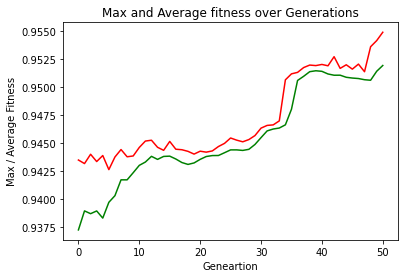

In [4]:
X, y = get_data(GSO_FLOW)

eval_class = Evaluation(X, y, SVR())



now = timeit.default_timer()
halloffame = tools.HallOfFame(HOF)

population = toolbox.populationCreator(n=POPULATION_SZIE)

generationCounter = 0

fitnessValues = list(map(toolbox.evaluate, population))

for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

fitnessValues = [individual.fitness.values[0] for individual in population]
halloffame.update(population)

maxFitnessValues = list()
meanFitnessValues = list()
all_time = list()


scores = list()
for antibody in population:
    scores.append(eval_class.getMeanR2(antibody))

maxFitness = np.max(scores)
meanFitness = np.mean(scores)
maxFitnessValues.append(maxFitness)
meanFitnessValues.append(meanFitness)
duration = timeit.default_timer() - now
all_time.append(duration)

print("_ Geneartion: %d Max Fitness: %.3f Avg Fitness %.3f" % (generationCounter, maxFitness, meanFitness))
print("Time: ", duration)

while generationCounter < MAX_GENERATIONS:
    now = timeit.default_timer()
    generationCounter = generationCounter + 1
    best_index = fitnessValues.index(max(fitnessValues))
    vaccine_local = population[best_index]
    offspring = toolbox.select(population, POPULATION_SZIE)
    offspring = list(map(toolbox.clone, offspring))


    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    for vaccinated in offspring:
        if random.random() < P_VACCINATION:
            toolbox.vaccine(vaccinated, vaccine_local)
            del vaccinated.fitness.values

            
    offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
    halloffame.update(offspring)
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue

    freshFitnessValues = [ind.fitness.values[0] for ind in offspring]

    population = toolbox.anealing_selection(freshIndividuals, POPULATION_SZIE)
    fitnessValues = [ind.fitness.values[0] for ind in population]
    
    scores = list()
    for antibody in population:
        scores.append(eval_class.getMeanR2(antibody))

    maxFitness = np.max(scores)
    meanFitness = np.mean(scores)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    duration = timeit.default_timer() - now
    all_time.append(duration)
    print("_ Geneartion: %d Max Fitness: %.5f Avg Fitness %.5f" % (generationCounter, maxFitness, meanFitness))
    print("Time: ", duration)
    

    
best_index = fitnessValues.index(max(fitnessValues))
print("Best Individual = ", population[best_index])
print("Best R2: %.5f" % eval_class.getMeanR2(population[best_index]))
print("Number of features Selected: %d" % sum(population[best_index]))
print("Total Time Consumed: %.3f minutes" % float(sum(all_time)/60))



plt.plot(maxFitnessValues, color="red")
plt.plot(meanFitnessValues, color="green")
plt.xlabel("Geneartion")
plt.ylabel("Max / Average Fitness")
plt.title("Max and Average fitness over Generations")
plt.savefig("plots/GSO_SVR_immune_local_plot", dpi=1000)
plt.show()

with open('objects/GSO_SVR_immune_local.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([maxFitnessValues, meanFitnessValues, population[best_index], population], f)